# QRS training data Preprocessor

Data preprocessor to build the training and validation data for our neural network

This notebook implementes all the necessary steps to run the computations needed to create the training and test data files.

## Importing libraries

In [1]:
import wfdb
import traceback
from wfdb import processing
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import traceback
from scipy import signal

## Creating the parabola function

This function will create a parabola around a spike in order to give it more width so it can be more easily detected

In [2]:
# auxiliary function
def parabola(a,n,r):
    """
    Creates a parabola around the position of a spike specified in 'a'
    Params:
        a - A vector specifying peak positions
        n - The length of the target vector to generate
        r - The radius of the parabola
    """
    assert n>2*r
    y = np.zeros(n, dtype = np.float32)
    x= np.array(range(2,2*r+1))
    for i in a:
        if i > r-1 and i <= n-r:
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y

## Preprocessing the files

We iterate all the files and for each of them we read channels II and V1.

After reading the channels we separate them into two distinct arrays in order to then join them into one 1D array.

We filter out undesired lines, i.e., lines that do not have a QRS symbol specified in `qrs_symbs` list.

The negative positions in the `qrs_symbs` list are also filtered out.

Once the lines are filtered we create a parabola around the spikes of our labels to better identify them, this completes the preprocessing of the data and we are now ready to create an output dictionary to be serialized into a file with `pickle`

### Preprocessing of the training datafiles

In [15]:
files_not_to_read = [4,17,35,44,57,72,74]
for i in range(1, 76):
    
    if i not in files_not_to_read:
        file_path = f"./data/Training/I{i:02}"
        output_file_name = f"./processed_data/Training/I{i:02}"
        try:
            # Reading the channels of interest
            sign, info = wfdb.rdsamp(file_path, channel_names = ["II", "V1"])

            # Reading the annotations
            annotations = wfdb.rdann(file_path, "atr")

            sign, annotations = processing.resample_multichan(sign, annotations, 257, 360)

            # Separating the two signals so we can put them in one dimension
            signal_II = sign[:, 0]
            signal_V1 = sign[:, 1]
            
            # Set moving average window size
            windowSize = 360
            window = np.ones(windowSize)/windowSize
            
            # Remove baseline by applying convolution with window (moving average filter)
            filtered = signal.convolve(signal_II, window, mode='same')
            signal_II = signal_II - filtered
            filtered = signal.convolve(signal_V1, window, mode='same')
            signal_V1 = signal_V1 - filtered
            
            symbol_positions = annotations.sample
            symbol_list = annotations.symbol

            # Filtering out all the lines that do not have a QRS symbol

            qrs_symbs = ['N','L','R','B','A','a','J','S','V','r','F','e','j', 'n', 'E', '/', 'f', 'Q',' ?']

            qrs_symbol_positions = [symbol_positions[idx] for idx, symb in enumerate(symbol_list) if symb in qrs_symbs]

            # Some peak positions are negative values, we are filtering these negative values out
            qrs_symbol_positions = [item for item in qrs_symbol_positions if item >= 0]

            target_vec = parabola(qrs_symbol_positions, len(sign), 3)

            output_dict = {
                "channelII": signal_II,
                "channelV1": signal_V1,
                "label": target_vec
            }

            pkl.dump(output_dict, open(output_file_name, "wb"), protocol=pkl.HIGHEST_PROTOCOL)
        except:
            traceback.print_exc()
            print(f"Error on file {file_path}")

Example on how to read a file

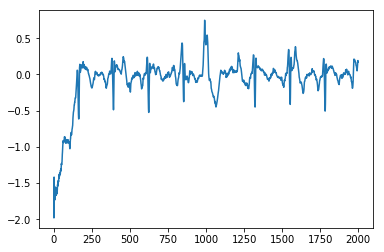

In [14]:
data_dict = pkl.load(open("./processed_data/Training/I01", "rb"))
test = data_dict["channelV1"]
plt.plot(test[:2000])

### Preprocessing of the test datafiles

In [16]:
nofile_indexes = [110, 120, 204, 206, 211, 216, 218, 229]
nofile_indexes = nofile_indexes + list(range(125,200)) + list(range(224,228))

for i in range(100, 235):
    
    if i not in nofile_indexes:
        file_path = f"./data/Test/{i}"
        output_file_name = f"./processed_data/Test/{i}"
        try:
            # Reading the channels of interest
            sign, info = wfdb.rdsamp(file_path)
            # Separating the two signals so we can put them in one dimension
            signal_II = sign[:, 0]
            signal_V1 = sign[:, 1]

            # Set moving average window size function
            windowSize = 360
            window = np.ones(windowSize)/windowSize
            
            # Remove baseline by applying convolution with window (moving average filter)
            filtered = signal.convolve(signal_II, window, mode='same')
            signal_II = signal_II - filtered
            filtered = signal.convolve(signal_V1, window, mode='same')
            signal_V1 = signal_V1 - filtered

            # Reading the annotations
            annotations = wfdb.rdann(file_path, "atr")
            symbol_positions = annotations.sample
            symbol_list = annotations.symbol
            
            # Filtering out all the lines that do not have a QRS symbol

            qrs_symbs = ['N','L','R','B','A','a','J','S','V','r','F','e','j', 'n', 'E', '/', 'f', 'Q',' ?']

            qrs_symbol_positions = [symbol_positions[idx] for idx, symb in enumerate(symbol_list) if symb in qrs_symbs]

            # Some peak positions are negative values, we are filtering these negative values out
            qrs_symbol_positions = [item for item in qrs_symbol_positions if item >= 0]

            target_vec = parabola(qrs_symbol_positions, len(sign), 3)

            output_dict = {
                "channelII": signal_II,
                "channelV1": signal_V1,
                "label": target_vec
            }

            pkl.dump(output_dict, open(output_file_name, "wb"), protocol=pkl.HIGHEST_PROTOCOL)
        except:
            #traceback.print_exc()
            print(f"Error on file {file_path}")

Example on how to read a file

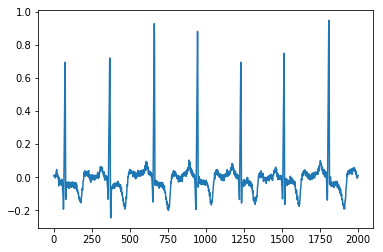

In [17]:
data_dict = pkl.load(open("./processed_data/Test/100", "rb"))
test = data_dict["channelV1"]
plt.plot(test[:2000])